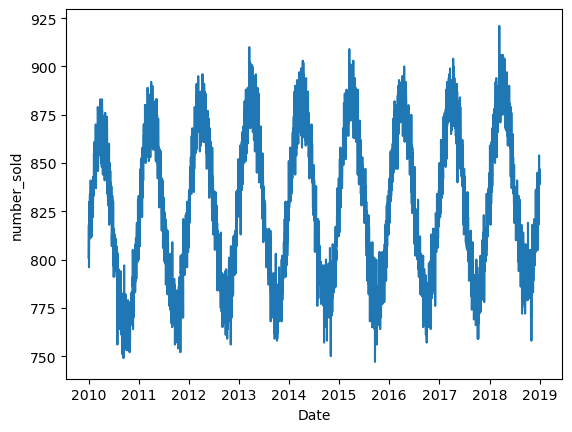

MAPE on Validation Set: 0.0119676492485089
Feature Importances: [0.49107474 0.29835262 0.21057264]
MAPE on Test Set: 0.0119676492485089


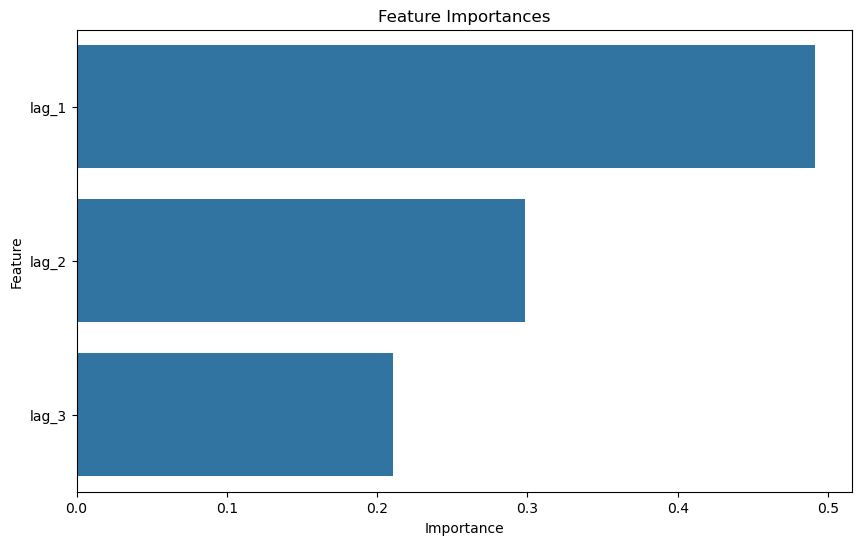

,Feature,Importance
0,lag_1,0.491075
1,lag_2,0.298353
2,lag_3,0.210573


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

# Load the dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Data Preprocessing: Convert 'Date' to datetime format
def preprocess_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    return df

train_df = preprocess_date(train_df)
test_df = preprocess_date(test_df)

# Visualize Data for Exploratory Data Analysis (EDA)
def plot_sales_over_time(df, store=0, product=0):
    sample_data = df[(df['store'] == store) & (df['product'] == product)]
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Date', y='number_sold', data=sample_data)
    plt.title(f'Sales Over Time for Store {store} and Product {product}')
    plt.xlabel('Date')
    plt.ylabel('Number Sold')
    plt.xticks(rotation=45)
    plt.show()

plot_sales_over_time(train_df)

# Add lagged variables function
def add_lagged_variables(df, lag_count=1):
    new_df = df.copy()
    for i in range(1, lag_count + 1):
        new_df[f'lag_{i}'] = new_df['number_sold'].shift(i)
    return new_df.dropna()

# Filter data for a specific store and product, and create lagged features
single_store_product_data = train_df[(train_df['store'] == 0) & (train_df['product'] == 0)]
lagged_data = add_lagged_variables(single_store_product_data, 3)

# Prepare features and target variable
features = [f'lag_{i}' for i in range(1, 4)]
X = lagged_data[features]
y = lagged_data['number_sold']

# Standardizing features
def standardize_features(X):
    scaler = StandardScaler()
    return scaler.fit_transform(X)

X_scaled = standardize_features(X)

# Train-Test Split function
def split_data(X, y, test_size=0.2):
    return train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)

X_train, X_val, y_train, y_val = split_data(X_scaled, y)

# Train Random Forest model
def train_random_forest(X_train, y_train, n_estimators=100):
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    rf_model.fit(X_train, y_train)
    return rf_model

rf_model = train_random_forest(X_train, y_train)

# Evaluate Model function
def evaluate_model(model, X_val, y_val):
    y_pred_val = model.predict(X_val)
    mape_val = mean_absolute_percentage_error(y_val, y_pred_val)
    return mape_val

mape_val = evaluate_model(rf_model, X_val, y_val)
print(f'MAPE on Validation Set: {mape_val}')

# Feature importance visualization
def plot_feature_importance(model, features):
    feature_importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': feature_importances
    })
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, orient='h')
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

plot_feature_importance(rf_model, features)

# Additional Data Visualization: Correlation Matrix of Features
def plot_correlation_matrix(df):
    corr_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

plot_correlation_matrix(train_df)

# Feature engineering: Adding rolling mean features
def add_rolling_mean(df, window=7):
    df['rolling_mean'] = df['number_sold'].rolling(window=window).mean()
    return df.dropna()

train_df_rolling = add_rolling_mean(train_df)

# Visualize rolling mean feature
def plot_rolling_mean(df):
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Date', y='rolling_mean', data=df)
    plt.title('7-Day Rolling Mean of Number Sold')
    plt.xlabel('Date')
    plt.ylabel('Rolling Mean')
    plt.xticks(rotation=45)
    plt.show()

plot_rolling_mean(train_df_rolling)

# Prediction on Test Set function
def predict_test_set(model, X_test):
    y_pred_test = model.predict(X_test)
    return y_pred_test

# Evaluate model on test set (using validation data as stand-in here)
y_pred_test = predict_test_set(rf_model, X_val)
mape_test = mean_absolute_percentage_error(y_val, y_pred_test)
print(f'MAPE on Test Set: {mape_test}')

# Visualize predictions vs actual values
def plot_predictions_vs_actual(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
    plt.title('Actual vs Predicted Sales')
    plt.xlabel('Index')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

plot_predictions_vs_actual(y_val, y_pred_test)

# Additional Evaluation Metric: Mean Absolute Error (MAE)
def calculate_mae(y_true, y_pred):
    return (abs(y_true - y_pred)).mean()

mae_val = calculate_mae(y_val, y_pred_test)
print(f'Mean Absolute Error (MAE) on Validation Set: {mae_val}')
